In [1]:
using EzXML
using Plots
using FFTW
using DSP
using StatsPlots
using NPZ
using Statistics

# Laser Stimulation Feature

This notebook will attempt to visualise the fluctuation of O2 and LFP readings after laser stimulation has occurred.

## Importing LFP Data

In [2]:
# Get the XML metadata file

lfp_path = "Exp 2/R7/2022-05-11_17-39-17/Record Node 101/"
files_xml = root(readxml("../../data/$(lfp_path)Continuous_Data.openephys"))
sample_rate = parse(Int, firstelement(files_xml)["samplerate"])

recording = firstelement(firstelement(files_xml))

# Format XML data into Dict
files = Dict("processor" => recording["id"], "name" => [], "filename" => [], "position" => [], "bitVolts" => [])
for elem in eachelement(recording)
    push!(files["name"], elem["name"])
    filename = replace(elem["filename"], r"continuous$"=>"")
    push!(files["filename"], "$(filename)npz")
    push!(files["position"], elem["position"])
    push!(files["bitVolts"], elem["bitVolts"])
end

In [3]:
# Indexing lfp_data[channel, datapoint]

# Add data from each channel into a single matrix
n_datapoints = length(npzread("../../data/formatted-lfp/$(lfp_path)$(files["filename"][1])", ["data"])["data"][1:end-1024])
n_channels = length(files["filename"])
lfp_data = Array{Float32}(undef, n_channels, n_datapoints)
for i in 1:n_channels
    data = npzread("../../data/formatted-lfp/$(lfp_path)$(files["filename"][i])", ["data"])["data"][1:end-1024] .* parse(Float64, files["bitVolts"][i])
    lfp_data[i, :] = data
end

# Normalisation
for i in 1:n_channels
    lfp_data[i, :] = (lfp_data[i, :] .- mean(lfp_data[i, :])) ./ std(lfp_data[i, :])
end

In [4]:
# Add timestamps into vector 
# Timestamps are identical for each channel so this only needs to be done once
lfp_timestamps = npzread("../../data/formatted-lfp/$(lfp_path)$(files["filename"][1])", ["timestamps"])["timestamps"]
n_timestamps = length(lfp_timestamps)

lfp_timestamps_extended = [lfp_timestamps[i-1] + (lfp_timestamps[i] - lfp_timestamps[i-1]) * j / 1024 for i in 2:n_timestamps for j in 1:1024]
lfp_timestamps_extended ./= sample_rate

@assert length(lfp_timestamps_extended) == n_datapoints

In [5]:
events_data = npzread("../../data/formatted-lfp/$(lfp_path)all_channels.npz")

laser_timestamps = events_data["timestamps"][findall(x->x==0, events_data["channel"])]./1000 
laser_eventIds = events_data["eventId"][findall(x->x==0, events_data["channel"])]

lfp_laser = laser_timestamps[findall(x->x==1, laser_eventIds)]

17-element Vector{Float64}:
  326.7
  449.063
  494.585
  534.267
  626.499
  731.54
  817.746
 1050.248
 1137.999
 1216.344
 1299.674
 1382.94
 1466.053
 1524.079
 1623.609
 1623.611
 1623.613

## Extracting Envelope of LFP Data

In [6]:
# Compute the Fourier Transform
sampling_rate = 1000
F = fft(lfp_data[5,:])
freqs = fftfreq(length(lfp_data[5,:]), sampling_rate)

# Butterworth's low pass filter equation
function butterworth_low(freq, pass_freq, n=5)
    return 1 / (1 + (abs(freq) / pass_freq) ^ 2n)
end

# Butterworth's high pass filter equation
function butterworth_high(freq, pass_freq, n=5)
    return 1 / (1 + (pass_freq / abs(freq)) ^ 2n)
end

# Apply the Band-Pass Butterworth filter
band = [1, 45]
band_pass_F = copy(F)
for i in 1:length(band_pass_F)
    band_pass_F[i] = band_pass_F[i] * butterworth_high(freqs[i], band[1]) * butterworth_low(freqs[i], band[2]) 
end

banded_lfp_data = real(ifft(band_pass_F))
lfp_envelope = abs.(hilbert(banded_lfp_data))

1601536-element Vector{Float32}:
 0.4840621
 0.47606048
 0.46849513
 0.46158096
 0.4555128
 0.45045388
 0.4465335
 0.44383413
 0.44238713
 0.44216913
 ⋮
 0.5355678
 0.53447187
 0.5317506
 0.5275644
 0.5221081
 0.51560336
 0.50829214
 0.5004278
 0.4922661

## Importing O2 Data

In [7]:
# Indexing o2_data[datapoint, time/o2/flag]

o2_path = "Exp 2/R7/"
filename = "o2 r7.txt"
o2_data = []
open("../../data/$(o2_path)$(filename)") do file
    for line in eachline(file)
        if isdigit(line[1])
            data_element = split(line, "\t")  
            if length(data_element) == 3 && data_element[3] == "#* timeTick ON "
                data_element = [parse(Float32, data_element[1]), parse(Float32, data_element[2]), 1, 0]
            elseif length(data_element) == 3 && data_element[3] == "#* heatStim ON "
                data_element = [parse(Float32, data_element[1]), parse(Float32, data_element[2]), 0, 1]
            else
                data_element = [parse(Float32, data_element[1]), parse(Float32, data_element[2]), 0, 0]
            end
            push!(o2_data, data_element)
        end
    end
end
o2_data = reduce(vcat,transpose.(o2_data))
# Normalisation
o2_data[:,2] = (o2_data[:,2] .- mean(o2_data[:,2])) ./ std(o2_data[:,2])

o2_flags = o2_data[findall(x->x==1, o2_data[:,3]), 1]
o2_laser = o2_data[findall(x->x==1, o2_data[:,4]), 1]

14-element Vector{Float32}:
  328.293
  450.314
  495.567
  535.427
  627.203
  731.83
  817.893
 1049.617
 1137.307
 1215.715
 1298.518
 1381.277
 1464.387
 1522.613

## Band-Pass Filtering O2 Data

In [8]:
# Compute the Fourier Transform
sampling_rate = 1000
F = fft(o2_data[:,2])
freqs = fftfreq(length(o2_data[:,2]), sampling_rate)

band_pass_F = copy(F)
for i in 1:length(band_pass_F)
    band_pass_F[i] = band_pass_F[i] * butterworth_high(freqs[i], band[1], 5) * butterworth_low(freqs[i], band[2], 5)
end

banded_o2_data = real(ifft(band_pass_F))

1597615-element Vector{Float32}:
  0.16930062
  0.19742146
  0.22422598
  0.24892971
  0.27087831
  0.28958273
  0.30474013
  0.31624025
  0.32415706
  0.3287289
  ⋮
 -0.01409593
 -0.0061930106
  0.005298182
  0.020450648
  0.03915271
  0.06110085
  0.085804924
  0.112610064
  0.14073125

## Visualising Laser Stimulation Effect

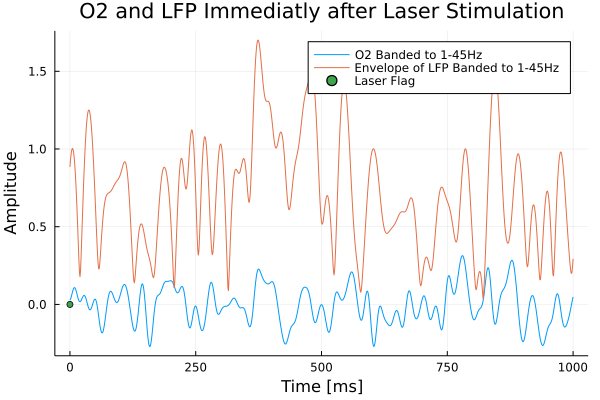

In [40]:
o2_start = findall(x->x==o2_laser[1], o2_data[:,1])[1]
lfp_start = findall(x->x==lfp_laser[1], lfp_timestamps_extended)[1]
increment = 1000
diff = o2_laser[1] - lfp_laser[1]

plot((o2_data[o2_start:o2_start+increment,1].-diff.-lfp_timestamps_extended[lfp_start]).*1000, banded_o2_data[o2_start:o2_start+increment], label="O2 Banded to 1-45Hz")
plot!((lfp_timestamps_extended[lfp_start:lfp_start+increment].-lfp_timestamps_extended[lfp_start]).*1000, lfp_envelope[lfp_start:lfp_start+increment], label="Envelope of LFP Banded to 1-45Hz")
scatter!([lfp_laser[1]].+diff.-o2_data[o2_start,1], zeros(1), label="Laser Flag")

title!("O2 and LFP Immediatly after Laser Stimulation")
xlabel!("Time [ms]")
ylabel!("Amplitude")